<a href="https://colab.research.google.com/github/amanshenoy/image-super-resolution/blob/master/isr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorboard for visual logging

In [0]:
%load_ext tensorboard 
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

# Imports

In [0]:
import torch, torch.nn as nn
import numpy as np
import torchvision, torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random
import subprocess
from PIL import Image

# Dataloaders

In [0]:
def load_loader_custom(crop_size: int = 33, batch_size: int = 128, num_workers: int = 1):
    """
    Loads the dataloader of the image directory using the given specifications
    input : crop_size -> image size of the square sub images the model has been trained on
            num_crops -> number of sub-images to consider for each image in the image directory  
    output: dataloader iterable to be able to train on the images
    """
    transform_high_res = transforms.Compose([
            transforms.CenterCrop(48),
            transforms.ToTensor()
        ])
    transform_low_res = transforms.Compose([
            transforms.CenterCrop(48),
            transforms.Resize(36),
            transforms.Resize(48, interpolation=3),
            transforms.ToTensor()
        ])
    dataset_high_res = torchvision.datasets.ImageFolder('.', transform = transform_high_res)
    dataset_low_res = torchvision.datasets.ImageFolder('.', transform = transform_low_res)
    dataloader_high_res = torch.utils.data.DataLoader(dataset_high_res, batch_size = batch_size, num_workers = num_workers, shuffle = False)
    dataloader_low_res = torch.utils.data.DataLoader(dataset_low_res, batch_size = batch_size, num_workers = num_workers, shuffle = False)
    return dataloader_low_res, dataloader_high_res

In [0]:
def load_loader_stl(crop_size: int = 33, batch_size: int = 128, num_workers: int = 1):
    transform_high_res = transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.ToTensor()
        ])
    transform_low_res = transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.Resize(int(crop_size / 1.5), interpolation=3),
            transforms.Resize(crop_size, interpolation=3),
            transforms.ToTensor()
        ])
    dataset_high_res = torchvision.datasets.STL10('.', transform = transform_high_res, download = True)
    dataset_low_res = torchvision.datasets.STL10('.', transform = transform_low_res, download = True)
    dataloader_high_res = torch.utils.data.DataLoader(dataset_high_res, batch_size = batch_size, num_workers = num_workers, shuffle = False)
    dataloader_low_res = torch.utils.data.DataLoader(dataset_low_res, batch_size = batch_size, num_workers = num_workers, shuffle = False)
    return dataloader_low_res, dataloader_high_res

# Models used

In [0]:
class SuperResolution(nn.Module):
    def __init__(self, sub_image: int = 33, spatial: list = [9, 5, 5], filter: list = [128, 64], num_channels: int = 3):
        super().__init__()
        self.layer_1 = nn.Conv2d(num_channels, filter[0], spatial[0], padding = spatial[0] // 2)
        self.layer_2 = nn.Conv2d(filter[0], filter[1], spatial[1], padding = spatial[1] // 2)
        self.layer_3 = nn.Conv2d(filter[1], num_channels, spatial[2], padding = spatial[2] // 2)
        self.relu = nn.ReLU()

    def forward(self, image_batch):
        x = self.layer_1(image_batch)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.layer_3(x)
        #x = torch.sigmoid(x)
        #x = self.relu(x)
        return x #+ image_batch # Heuristic since laptop cannot handle complete training

# Training loop

In [6]:
def train():
    low_res_loader, high_res_loader = load_loader_stl()
    model = SuperResolution()
    if torch.cuda.is_available():
        model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), 5e-04)
    writer = SummaryWriter()
    n = 0

    for epoch in tqdm(range(250), desc= "Training", ncols = 120):
        for low_res, high_res in zip(low_res_loader, high_res_loader):
            low_res_batch, high_res_batch = low_res[0], high_res[0]
            if torch.cuda.is_available():
                low_res_batch, high_res_batch = low_res_batch.cuda(), high_res_batch.cuda()
            reconstructed_batch = model(low_res_batch)
            loss_fn = nn.MSELoss()
            loss = loss_fn(high_res_batch, reconstructed_batch)
            loss_to_compare = loss_fn(high_res_batch, low_res_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            to_pil, resize, to_tensor = torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((48 * 7, 144 * 7)), torchvision.transforms.ToTensor()
            ind = 4
            image = to_pil(torch.cat((low_res_batch[ind], high_res_batch[ind], reconstructed_batch[ind]), dim = 2).cpu())
            image = to_tensor(resize(image))
            image = image.clamp(0, 1)
            n += 1
            psnr = 10 * torch.log10(1 / loss)
            psnr_tc = 10 * torch.log10(1 / loss_to_compare)

            writer.add_scalar("MSE loss between the images", loss * (255 ** 2), n)
            writer.add_scalar("PSNR", psnr, n)
            writer.add_scalar("Constant value PSNR must cross for model to be worthwhile", psnr_tc, n)
            writer.add_image("Low Resolution Image | High Resolution Image | Reconstructed Image", image, n, dataformats='CHW')

    return model

model = train()

Files already downloaded and verified
Files already downloaded and verified


Training: 100%|███████████████████████████████████████████████████████████████████████| 250/250 [40:30<00:00,  9.72s/it]


In [0]:
import gc 

def execute(image, model, fs = 33, overlap = False, scale = 1.5):
    model.eval()
    c, h, w = image.shape
    scale_transform, to_pil, to_tensor = transforms.Resize((int(h * scale), int(w * scale)), interpolation=3), transforms.ToPILImage(), transforms.ToTensor()
    image = to_tensor(scale_transform(to_pil(image)))
    c, h, w = image.shape
    image = image.unsqueeze(0)
    image = image.cuda()
    reconstructed_image = torch.zeros_like(image).cpu()
    reconstructed_image_weights = torch.zeros_like(image).cpu()
    if overlap:
      for i in tqdm(range(h - fs + 1), desc = 'Progressively Scanning'):
        for j in range(w - fs + 1):
          gc.collect()
          patch = image[:, :, i: i + fs, j: j + fs]
          reconstructed_image[:, i: i + fs, j: j + fs] += model(patch).cpu()
          reconstructed_image_weights[:, :, i: i + fs, j: j + fs] += torch.ones(1, c, fs, fs)
      reconstructed_image /= reconstructed_image_weights
    else:
      for i in tqdm(range(h // fs), desc = 'Progressively Scanning', ncols = 100):
        for j in range(w // fs):
          gc.collect()
          patch = image[:, :, i * fs: i * fs + fs, j * fs: j * fs + fs]
          reconstructed_image[:, :, i * fs: i * fs + fs, j * fs: j * fs + fs] = model(patch).cpu()
          reconstructed_image_weights[:, :, i * fs: i * fs + fs, j * fs: j * fs + fs] = torch.ones(1, c, fs, fs)
          if j == w // fs - 1:
              patch = image[:, :, i * fs: i * fs + fs, w - fs: w]
              reconstructed_image[:, :, i * fs: i * fs + fs, w - fs: w] = model(patch).cpu()
          if i == h // fs - 1:
              patch = image[:, :, h - fs: h, j * fs: j * fs + fs]
              reconstructed_image[:, :, h - fs: h, j * fs: j * fs + fs] = model(patch).cpu()
    print("Channels = {}, Image Shape = ({}, {})".format(c, w, h))
    return reconstructed_image

def transform_image(path_to_image):
    image = Image.open(path_to_image)
    to_tensor = torchvision.transforms.ToTensor()
    return to_tensor(image)

Progressively Scanning: 100%|███████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s]

Channels = 3, Image Shape = (330, 330)


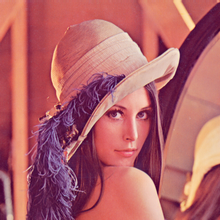

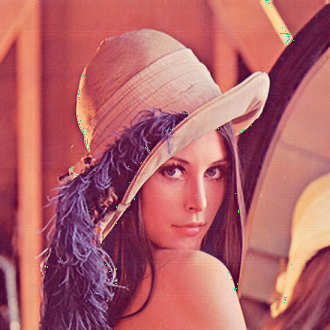

In [10]:
image_link = 'https://upload.wikimedia.org/wikipedia/en/thumb/7/7d/Lenna_%28test_image%29.png/220px-Lenna_%28test_image%29.png'
path_to_image = '/content/test.jpg'
subprocess.check_output('wget -O ' + path_to_image + ' ' + image_link, shell = True)
transformed = transform_image(path_to_image)
reconstructed = execute(transformed, model)
to_pil = torchvision.transforms.ToPILImage()

from IPython.display import display, HTML, clear_output
display(to_pil(transformed.squeeze()))
display(to_pil(reconstructed.squeeze()))